### Reconstruct all events using four GPUs and the CRS2 spherical optimizer running in batch mode

In [1]:
import pickle
import math
import time
import pkg_resources

from functools import partial
from multiprocessing import Process, Pool

import numpy as np

from freedom.llh_service.llh_service import LLHService
from freedom.reco import crs_reco
from freedom.reco import summary_df

In [2]:
#grab the datasets
#hits
hits=np.load('/fastio/wendel/test/hits.npy')
hitparams=np.load('/fastio/wendel/test/params.npy')
#charge
charge=np.load('/fastio/wendel/test/charge.npy')

ids=[]
for i in range(1,len(hitparams)):
    if all(hitparams[i-1]!=hitparams[i]):
        ids.append(i)
ids.append(len(hits))

#create events 
start=0
iteration=0
events=[]
for i in ids:
    event={
        "hits":  hits[start:i],
        "total_charge": charge[iteration],
        "truth": hitparams[start]     
    }
    start=i
    events.append(event)
    iteration+=1
    
#filter for hits>15

#events=[event for event in events if len(event['hits']) > 15]

len(events)

198206

### Specify n live points

In [3]:
n_live_points = 280*2

### Define allowed search ranges and initial box limits

In [4]:
# for reference labels=['x','y','z','zenith','azimuth','t','energy']
init_pos_range = 4700

time_range = (-50, -3)

log_energy_range = [0, .85]

init_range = np.array( [[-init_pos_range, init_pos_range],
                        [-init_pos_range, init_pos_range],
                        [-6700, 6700],
                        [0, math.pi],
                        [0, 2*math.pi],
                        [time_range[0], time_range[1]],
                        [log_energy_range[0], log_energy_range[1]]
                       ])

# define limits of search range 
param_search_limits = np.array([
    [-6700, 6700],
    [-6700, 6700],
    [-6700, 6700],
    [-0, math.pi],
    [0, 2*math.pi],
   [-200, -1],
    [1, 8]
]).T

In [5]:
print(param_search_limits[0,5])

-200.0


### llh service configuration:

In [6]:
service_conf = {
        "poll_timeout": 1,
        "flush_period": 1,
        "n_hypo_params": 7,
        "n_hit_features": 6,
        "n_evt_features": 2,
        "batch_size" : {
          "n_hypos": 200,
          "n_observations": 6000, 
        },
        "send_hwm": 10000,
        "recv_hwm": 10000,
#         "hitnet_file": "/home/atfienberg/freedomDataCopy/public_for_aaron/HitNet_ranger_30_Jul_2020-15h49/epoch_32_model.hdf5",
#         "domnet_file": "/home/atfienberg/freedomDataCopy/public_for_aaron/DOMNet_reduced_22_Jul_2020-15h18/epoch_30_model.hdf5",
        "hitnet_file": "hitman_0kHz.h5",
        "chargenet_file": "chargenet_0kHz.h5"
    
}

In [7]:
# add hit_data, evt_data keys based on the networks being used
# for now, support domnet and chargenet
for event in events:
    if service_conf['n_hit_features'] == 8:
        event['hit_data'] = event['hits'][:, :8]
    else:
        event['hit_data'] = event['hits']
        
    if 'domnet_file' in service_conf:
        event['evt_data'] = event['doms'][allowed_DOMs]
    else:
        event['evt_data'] = event['total_charge']

### Build four services, one per GPU

In [8]:
n_gpus = 4

In [9]:
base_req = "ipc:///tmp/gmwrecotestreq"
base_ctrl = "ipc:///tmp/gmwrecotestctrl"

req_addrs = []
ctrl_addrs = []
for i in range(n_gpus):
    req_addrs.append(f'{base_req}{i}')
    ctrl_addrs.append(f'{base_ctrl}{i}')

In [10]:
print(req_addrs)
print(ctrl_addrs)

['ipc:///tmp/gmwrecotestreq0', 'ipc:///tmp/gmwrecotestreq1', 'ipc:///tmp/gmwrecotestreq2', 'ipc:///tmp/gmwrecotestreq3']
['ipc:///tmp/gmwrecotestctrl0', 'ipc:///tmp/gmwrecotestctrl1', 'ipc:///tmp/gmwrecotestctrl2', 'ipc:///tmp/gmwrecotestctrl3']


In [11]:
procs = []
for i in range(n_gpus):
    proc = Process(target=crs_reco.start_service, args=(service_conf, ctrl_addrs[i], req_addrs[i] ,i))
    proc.start()
    procs.append(proc)

starting service work loop for gpu 0...
starting service work loop for gpu 1...
starting service work loop for gpu 3...
starting service work loop for gpu 2...


### Fit a single event

In [22]:
%%time
event=0

test_out = crs_reco.fit_events(events[event:event+1], 0, ctrl_addrs, init_range, 
                               param_search_limits, n_live_points,
                               batch_size=28, spherical_indices=[[4,3]])

CPU times: user 996 ms, sys: 44 ms, total: 1.04 s
Wall time: 6.62 s


In [23]:
print(test_out[0][0]['fun'])
print(test_out[0][1])
print('---')
print(test_out[0][0]['n_calls'])
print(test_out[0][0]['nit'])
print(test_out[0][0]['x'])
print(events[event]['truth'])
r=test_out[0][0]['x']-events[event]['truth']
print((r[0]**2+r[1]**2+r[2]**2)**.5)
print((r[0]**2+r[1]**2)**.5)
print(len(events[event]['hits']))

-14.559379
-9.090492
---
13653
300
[-3.60196835e+00  2.82239033e+03  2.53548087e+03  1.82076678e-01
  4.31458426e+00 -7.28952008e+01  1.49079916e+00]
[ 1.44541619e+02  2.78790012e+03  4.11572463e+03  2.80981983e-01
  5.96531219e+00 -6.98107532e+01  6.45354605e+00]
1587.5473023116454
152.10554677705593
7


In [195]:
# events_to_process = len(events)
events_to_process = 1000
etp=events_to_process
pool_size = 100
evts_per_proc = int(math.ceil(events_to_process/pool_size))
evt_splits = [events[i*evts_per_proc:(i+1)*evts_per_proc] for i in range(pool_size)]
print(sum(len(l) for l in evt_splits))

1000


In [196]:
gpu_inds = np.arange(pool_size) % n_gpus

In [197]:
fit_events_partial = partial(
        crs_reco.fit_events,
        ctrl_addrs=ctrl_addrs,
        init_range=init_range,
        search_limits=param_search_limits,
        n_live_points=n_live_points,
        spherical_indices=[[4,3]],
        batch_size=28,
)

In [198]:
%%time
start = time.time()
# reconstruct with a worker pool; one LLH client per worker
with Pool(pool_size) as p:
    outs = p.starmap(fit_events_partial, zip(evt_splits, gpu_inds))
delta = time.time() - start

CPU times: user 0 ns, sys: 10.2 s, total: 10.2 s
Wall time: 1min 40s


In [199]:
print(f'measured time: {delta/60:.1f} minutes')

measured time: 1.7 minutes


In [200]:
print(sum(len(out) for out in outs))

1000


In [201]:
n_params = len(events[0]['truth'])

In [202]:
all_outs = sum((out for out in outs), [])

Note: the following timing is from running on four Titan X GPUs in parallel

In [203]:
total_calls = sum(out[0]['n_calls'] for out in all_outs)
total_iters = sum(out[0]['nit'] for out in all_outs)
print(f'{total_calls} total calls')
time_per_call = delta/total_calls
print(f'{total_iters} total iters')
time_per_iter = delta/total_iters
print(f'{total_calls/len(all_outs):.1f} calls per event')
print(f'{time_per_call*1e6:.2f} us per call')

print(f'{total_iters/len(all_outs):.1f} iters per event')
print(f'{time_per_iter*1e6:.2f} us per iter')

6155787 total calls
135833 total iters
6155.8 calls per event
16.31 us per call
135.8 iters per event
739.04 us per iter


In [204]:
'''
event=3
print(all_outs[event][0]['x'])
print(all_outs[event][0]['fun'])
print(all_outs[event][1])

print(all_outs[event][0]['x'])
print(events[event]['truth'])
print(all_outs[event][0]['x']-events[event]['truth'])
rs=[]
'''
rs=[]
for event in range(0,etp):
    r=all_outs[event][0]['x']-events[event]['truth']
    r=(r[0]**2+r[1]**2+r[2]**2)**.5
    rs.append(r)
    
print(rs)

np.average(rs)


[582.6289266869683, 678.6594089744383, 3962.545009183816, 704.171472755064, 1632.2369687014198, 721.4431211488736, 484.10415052198385, 413.60592556129046, 2387.7343482776314, 730.9203288509508, 2701.382709471744, 930.9798341527431, 220.2224909363277, 799.4650224241619, 578.1465305959292, 1203.264462291741, 384.4771488299133, 563.2801196792062, 646.7353170100728, 386.42335901514673, 392.965157783148, 670.8928209860433, 318.4300999395677, 355.8223873680858, 652.5446324327636, 949.206238723014, 166.01613670463678, 491.19338292594244, 1225.2235209570267, 564.024049891101, 854.7873595067387, 564.6746588576103, 710.4126745020204, 766.5525495814733, 183.60213938820726, 150.6826551294061, 373.8631170912046, 332.940682229985, 1082.3909429947464, 699.6493553421217, 414.5956492489258, 226.80134391883982, 769.2571131048733, 698.1116529901287, 280.9184614016126, 951.8263241771958, 792.0557933354983, 464.18463607589473, 1425.0413346246435, 229.81649694464716, 1169.1488451788455, 1275.7134324419826, 

733.896727546287

15
[nan, 124.98858524648367, 119.26131648810511, 84.23473696613932, 86.58091795649628, 89.61504574758702, 89.07263962003204, 70.85780176796865, 76.73538635251334, 65.5733223244204, 63.81465307223738, 58.92207559137836, 59.99797473316189, 57.79717160472692]


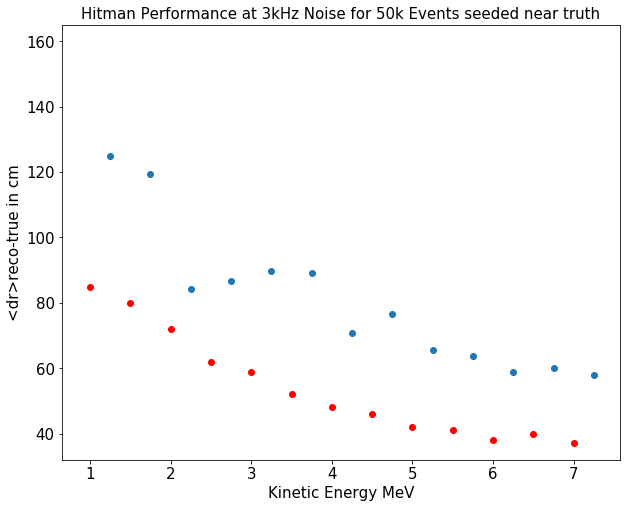

In [206]:
#for 24 1000: 2033
#for 12 97 :  2100
# 2000 events  2122
import matplotlib.pyplot as plt
def generate_plotdata(rs,events,intervals):
    avg=[]
    x=[event['truth'][6] for event in events]
    x=np.array(list(zip(rs,x[0:len(rs)])))
    dr=np.array(rs)
    energy=np.array(x[0:len(rs)])
    for i in range(0,len(intervals)-1):
        avg.append(np.average(dr[np.where((energy>intervals[i]) & (energy<intervals[i+1]))[0]])/10)
    return avg
intervals=[i/2 for i in range(1,16)]
print(len(intervals))
print(generate_plotdata(rs,events,intervals))
len(intervals)
plt.figure(figsize=[10,8])
plt.ylim([32,165])
plt.scatter(np.array(intervals)[:-1]+.25,generate_plotdata(rs,events,intervals))
plt.scatter(np.array(intervals)[1:-1],[85,80,72,62,59,52,48,46,42,41,38,40,37],color='r')
plt.title('Hitman Performance at 3kHz Noise for 50k Events seeded near truth',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('<dr>reco-true in cm',fontsize=15)
plt.xlabel('Kinetic Energy MeV',fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()


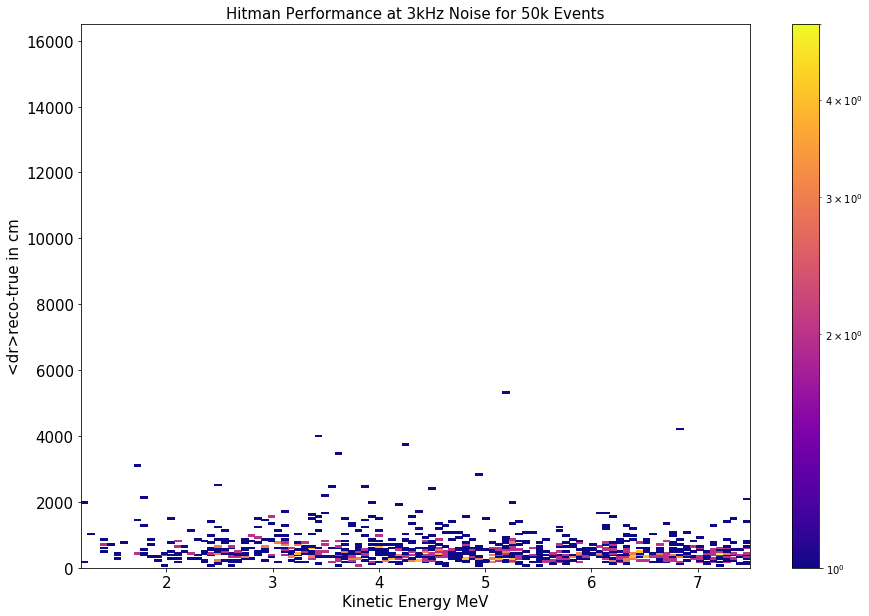

459.1669653937714


In [146]:
import matplotlib.colors as colors

plt.figure(figsize=[15,10])
plt.hist2d([event['truth'][6] for event in events][0:len(rs)],rs,bins=100,cmap='plasma',norm=colors.LogNorm())
plt.colorbar()
plt.title('Hitman Performance at 3kHz Noise for 50k Events',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0,16500])
plt.ylabel('<dr>reco-true in cm',fontsize=15)
plt.xlabel('Kinetic Energy MeV',fontsize=15)
plt.show()
np.max(np.array(rs))
#print(rs)
print(np.median(rs))

In [24]:
free_f_better = df[df.free_fit_llh < df.retro_p_llh + 10]
frac = len(free_f_better)/len(df)
print(f'free fit better frac: {frac:.2f}')

free fit better frac: 0.98


In [25]:
bad = df[df.free_fit_llh >= df.retro_p_llh + 5]

In [106]:
bad.head()

NameError: name 'bad' is not defined

In [27]:
df.to_pickle('./test_out.pkl')

In [24]:
# kill all the services
import zmq
for proc, ctrl_addr in zip(procs, ctrl_addrs): 
    with zmq.Context.instance().socket(zmq.REQ) as ctrl_sock:
        ctrl_sock.connect(ctrl_addr)
        ctrl_sock.send_string("die")
        proc.join()

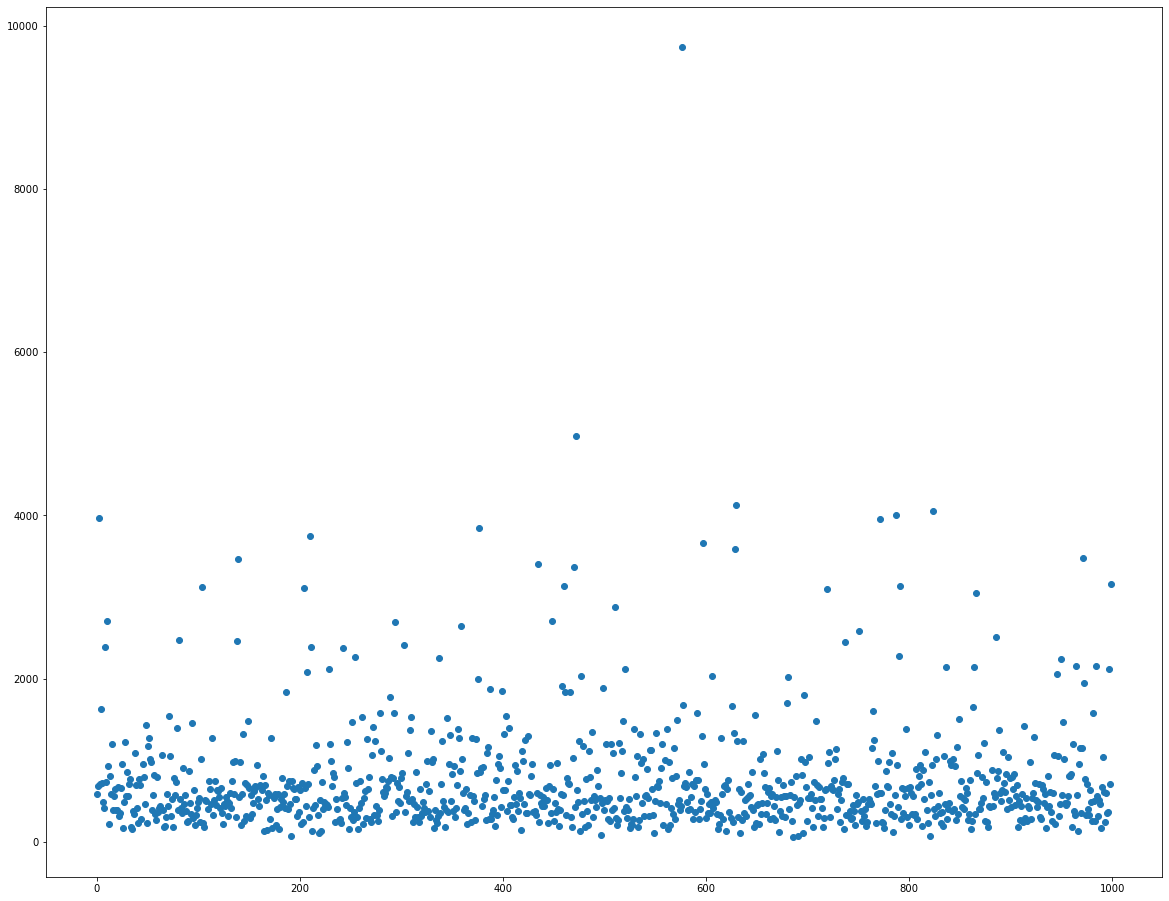

In [205]:
plt.figure(figsize=[20,16])
plt.scatter([i for i in range(0,len(rs))],rs)

[True]